# Graph Neural Network
---
> Graph neural network model for vertex dynamics and tension prediction

**To-Do**👷🚧

- *Training loop*:
    - [ ] Combine `Message` and `AggregateUpdate` into a graph layer `GraphBlock`
- [ ] Write *prediction stage*: read \{test, val, train\} data and predict w/ saving. 1-step and rollout error measurements.
- [ ] Run more simul-s. Save them as both 1-frame and rollout datasets (in rollout dataset keep each movie as a seperate dataset).
- [ ] Experiments (**save all models** w/ backups; will need to test on the real tensions)<br>
*Params*: edge attrib-s, cell layer, arch(skip con-s), input noise (for long term prediction). *Errors*: 1-step, and rollout error (check after training at test time).
    1. Experiment with GN arch-s w/ *residual* (w/ skip) and *non-residual* architectures.
    1. Find a *rough number of layers* (Mess. passing steps) and hidden *dim-s sizes* for var-s. --> Initial estimates for next experiments.
    1. *Edge directions experiment*: train w/ and w/o edge dir-s, do edge dir-s help to speed up training?
    1. *Cell layer*: does having dedicated cell processing layer help to increase the accuracy?
    1. For best (resnet or non-resnet) run *number of layers and dim-n sizes*. Try deep nets, how does accuracy change with increasing the depth of the net?
    1. If resnet is better: try w/and w/o edge dir-s and "cell layers".
    1. Number of previous velocities (window size).
    1. Rollout experiment 1— *input noise*: according to Sanchez-Gonzalez, *et al.* \[ASG2020\], Brownian noise improves rollout accuracies (long term accuracy of the whole movie, and/or prediction stability/robustness).
    1. Rollout experiment 2— *rollout training*: train directly on rollout, i.e. use 5- and 10-step loss instead of a 1-step loss for training (slower training).
    1. Optional:
        - compare MLP vs CONV layers for message passing.
        - try with dynamic graphs (construct graphs on the fly based on relative positions, and use cell edges and cell attrib only for queries on `Y_edge`, `Y_cell`).
- [ ] Ablation dataset (*real*).

---
**DOING**🛠
1. Training loop w/ validation set error monitoring, and best model saving.
1. Construct graph net without skip connections.
1. Combine Message and AggregateUpdate into a graph layer GraphNet (GN) block, a more general block, that can be composed into a deep residual network. "AddGN" block, w/ `AddGN(x) = f(x)+x` form (in fact, where it's possible make all blocks with this form.
1. Construct residual net out of GNs.
---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path

from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T

from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
matplotlib.rcParams['font.size']= 14 # use 14 for presentation

In [3]:
from simgnn.datasets import VertexDynamics, HaraMovies
from simgnn.nn import mlp, Message, AggregateUpdate, Aggregate
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, ScalePressure
# from torch_geometric.utils import to_undirected as T_undir

In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cpu
 |-dtype : torch.float32


## Datasets

---
- Data pre-processing and normalisation:
    - Simulation datasets: `l_av=0.857`
        - `Pos2Vec(scale=10*0.857)`
        - `ScaleVelocity(0.5*0.857)`
        - `ScaleTension(5,shift=1.45)`
        - `ScalePressure(3, shift=1.0)`

    - Hara movies: `l_av=26.32`
        - `Pos2Vec(scale=10*26.32)`
        - `ScaleVelocity(0.5*26.32)`

### Hara Movies Dataset (no force information)

HaraMovies(165)

Frame 1:
CellData(cell2node_index=[2, 492], edge_attr=[225, 2], edge_index=[2, 225], node2cell_index=[2, 492], pos=[164, 2], x=[164, 5, 2], y=[164, 2])


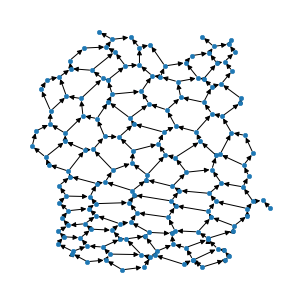

In [26]:
T_hara_norm = T.Compose([Pos2Vec(scale=10*26.32) , ScaleVelocity(0.5*26.32)]) # data normalisation

hara_movs = HaraMovies('simgnn_data/hara_movies/', transform=T_hara_norm)
mov_i = hara_movs[0]

print('{}\n\nFrame 1:\n{}'.format(hara_movs,mov_i))
plt.figure(figsize=[4,4])
nx.draw(to_networkx(mov_i),pos=dict(enumerate(mov_i.pos.numpy())), node_size=20)

### Synthetic Datasets (Train , and Val)

VertexDynamics(95) 
 CellData(cell2node_index=[2, 600], cell_pressures=[100], edge_attr=[339, 2], edge_index=[2, 339], edge_tensions=[339], node2cell_index=[2, 600], pos=[240, 2], x=[240, 5, 2], y=[240, 2])


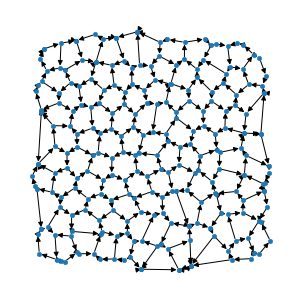

In [27]:
# Normalisation: for simulated data
Tnorm = T.Compose([Pos2Vec(scale=10*0.857) , ScaleVelocity(0.5*0.857), ScaleTension(5,shift=1.45),  ScalePressure(3, shift=1.0)])

# training dataset
vtxdata = VertexDynamics('../../../dataDIR/simgnn_data/train/', transform=Tnorm)
# validation dataset (also simulation): val = VertexDynamics('../../../dataDIR/simgnn_data/val/')

print(vtxdata,'\n',vtxdata[0])
plt.figure(figsize=[4,4])
nx.draw(to_networkx(vtxdata[0]),pos=dict(enumerate(vtxdata[0].pos.numpy())), node_size=20)

## Training

- **Examples**:
    - General "Message Passing" schemes: a nice example for composite graph layer –"meta layer" consisting of "edge", "node" and "global" layers [link](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.meta.MetaLayer)

**Node-to-Cell Encoding/Pooling Layer**:
1. Initiate node-to-cell edge attr-s as (source) node attr-s `x[node2cell_index[0]]`.
1. Compute node-to-cell edge attr-s using MLP: `e_n2c = MLP( x[node2cell_index[0]] )`
1. Aggregate node-to-cell edge attr-s as cell attr-s : `x_cell = Aggregate(e_n2c)`
1. Compute new cell attr-s using (encodes `x_cell` into cell attr-s) : `h_cell = MLP_Cell_encoder( x_cell )`

```python
n2c_model = mlp(...) # "message", just node-wise MLP
cell_aggr = Aggregate()
cell_enc = mlp(...)

e_n2c = n2c_model(data.x)[data.node2cell_index[0]]
x_cell = cell_aggr(data.cell_pressures.size(0), data.node2cell_index, e_n2c)
h_cell = cell_enc(x_cell)
```

---
- **Adding noise from M steps**: Sum of M normal rand. var-s results in normal var. w/ variance M and s.t.d.=sqrt(M):
```python
x = np.random.normal(size=(5,1000))
y = x.sum(axis=0)
z = np.random.normal(size=(1,1000))*np.sqrt(5)
plt.hist(x.ravel(),bins=50,label='x',density=True)
plt.hist(y        ,bins=50,label='y',density=True)
plt.hist(z.ravel(),bins=50,label='z',density=True,alpha=.5)
plt.legend();
```

`CellData` prop-s (graph data objects):
- `x` : `(#nodes, WindowWidth, 2)` *node features*
- `y` : `(#nodes, 2)` *node targets (velocities)*.
- `pos` : `(#nodes, 2)` *node positions*.
- `edge_attr` : `(#edges, 2)` or `(#edges, #edge_features)` *edge features  (relative Cartesian positions of connected nodes)*.
- `edge_index` : `(2, #edges)` *edge indices*.
- `edge_tensions` : `(#edges,)` *edge targets (line tensions)*.
- `node2cell_index` : `(2, #cell2node_edges)`, `node2cell`-> *first row is node indices and second row is cell indices;
- `cell2node_index` : `(2, #cell2node_edges)`, `cell2node`-> *first row is cell indices and second row is node indices*.
- `cell_pressures` : `(#cells,)` *cell targets (cell pressures)*.

In [44]:
# in order to track the batch id for var-s add its key to "follow_batch":
loader = DataLoader(vtxdata, batch_size=2,follow_batch=['cell_pressures','edge_index'])
# this tracks batch id for "cell_pressures_batch" and "edge_index_batch" in addition to node batch ids
batch = next(iter(loader))
# nx.draw( to_networkx(
#     CellData(num_nodes = torch.sum(batch.batch==0).item(),
#              edge_index = batch.edge_index[:,batch.edge_index_batch==0])),
#     pos=dict(enumerate(batch.pos[batch.batch==0].numpy())),
#     node_size=60, node_color='r',edge_color='r')
# nx.draw( to_networkx(
#     CellData(num_nodes = torch.sum(batch.batch==1).item(),
#              edge_index = batch.edge_index[:,batch.edge_index_batch==1]-240)),
#     pos=dict(enumerate(batch.pos[batch.batch==1].numpy() +1.5)),
#     node_size=60)
batch

Batch(batch=[480], cell2node_index=[2, 1200], cell_pressures=[200], cell_pressures_batch=[200], edge_attr=[678, 2], edge_index=[2, 678], edge_index_batch=[678], edge_tensions=[678], node2cell_index=[2, 1200], pos=[480, 2], x=[480, 5, 2], y=[480, 2])

**Training Loop**

In [7]:
mse_loss = torch.nn.MSELoss(reduction='sum')
l1_loss = torch.nn.L1Loss(reduction='sum')

model_states = ['train', 'val', 'hara']
loss_funcs = {'MSE':mse_loss,'MAE':l1_loss}

In [11]:
net = mlp(4,8,hidden_dims=[])
opt = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

mlp(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
  )
)

In [ ]:
import time
import copy
import torch

In [ ]:
mse_loss = torch.nn.MSELoss(reduction='sum')
l1_loss = torch.nn.L1Loss(reduction='sum')

def train_model(model, data_loaders, optimizer, num_epochs = 5, scheduler = None,
                device = torch.device('cpu'),
                model_states = ['train', 'val', 'hara'],
                loss_metric = 'MAE',
                loss_funcs = {'MSE':mse_loss,'MAE':l1_loss},
                return_best = False):
    '''
    docs
    '''
    # for logging and tracking
    train_params = {state+'_'+metric for state in model_states for metric in loss_funcs}
    train_params['loss_metric'] = loss_metric
    train_params['total_epochs'] = num_epochs
    train_params['optimizer'] = optimizer.__repr__()
    train_params['scheduler'] = 'none' if scheduler is None else scheduler.__class__.__name__
    train_params['scheduler_params'] = 'none' if scheduler is None else scheduler.state_dict().__repr__()
    train_params['return_best'] = return_best
    
    time_start = time.time()
    best_wts = copy.deepcopy(model.state_dict()) if return_best else None 
    best_loss = 0.0
    
    ### EDIT BELOW
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1} ---', end=' ')
        
        # set model state depending on training/eval stage
        for state in model_states:
            if state == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode
            
            running_loss = 0.0
            running_corrects = 0
            
            for samples in data_loaders[state]:
                # input HxW depend on transform function(s), 3 Channels
                inputs = samples['image'].to(device)
                # labels \in [0, 1, 2]
                labels = samples['label'].to(device)          
                
                # set grad accumulator to zero
                optimizer.zero_grad()

                with torch.set_grad_enabled(state == 'train'):
                    # grad tracking is disabled in "eval" mode
                    outputs = model(inputs) # output:(batch, #classes)
                    _, preds = torch.max(outputs, 1) # labels:(batch,)
                    loss = loss_func(outputs, labels) #<-torch.nn.CrossEntropyLoss
                    
                    if state == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0) # weighted loss
                running_corrects += torch.sum(preds == labels.detach() )
            
                # apply LR schedule
                if state == 'train' and scheduler!=None:
                    scheduler.step()

            epoch_loss = running_loss / len(data_loaders[state].dataset)
            epoch_acc = running_corrects.double() / len(data_loaders[state].dataset)
            
            curve_data[f'{state}Losses'].append(epoch_loss)
            curve_data[f'{state}Accs'].append(epoch_acc)
            
            print(f'{state} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}',end=' || ')
            
            # deep copy the model
            if state == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                if return_best:
                    # keep best weights to return
                    best_wts = copy.deepcopy(model.state_dict())
        print(f'{time.time() - time_start:.0f}s')
    time_elapsed = time.time() - time_start
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} (return best:{return_best})')
    
    if return_best:
        # load best model weights
        model.load_state_dict(best_wts)
    
    return model, train_params


In [ ]:
def train_model(model,x,y,ValData,optim, loss_func,
                epochs=100, test_intervl=25, print_times=10, scheduler=None):
    '''
    Arg-s:
    - x : input vectors (a tensor): x , or tuple of tensors :(x, Y0) for difference nets.
    - y : targets/labels ("actual y")
    - ValData : tuple (x_val,y_val), validation or testing dataset,
    for diffnet tuple of tuples ((x,Y0),y)
    - optim : optimizer/ solver
    - test_intervl: collect loss every "test_intervl" iter-n
    - print_times : number of times to print loss to the terminal
    - epochs : total number of training epochs == training iterations for the batch
    '''
    x_val, y_val = ValData
    is_diff_net_ = False
    if isinstance(x, tuple):
        is_diff_net_=True
        x, Y0 = x
        x_val, Y0_val = x_val
    # Losses just before training
    model.eval()
    train_epochs = [0]
    with torch.no_grad():
        if is_diff_net_:
            train_loss = [loss_func(model(x,Y0), y).item()]
            test_loss = [loss_func(model(x_val,Y0_val), y_val).item()]
        else:
            train_loss = [loss_func(model(x), y).item()]
            test_loss = [loss_func(model(x_val), y_val).item()]
    
    # Training iterations:
    for epoch in range(epochs):
        model.train()
        if is_diff_net_:
            pred = model(x,Y0)
        else:
            pred = model(x)
        loss = loss_func(pred, y)
        
        loss.backward()
        optim.step()
        optim.zero_grad()
        model.eval() # for validation
        with torch.no_grad():
            # save for plotting
            if epoch%test_intervl==0:
                if is_diff_net_:
                    train_loss.append(loss_func(model(x,Y0), y).item())
                    test_loss.append(loss_func(model(x_val,Y0_val), y_val).item())
                else:
                    train_loss.append(loss_func(model(x), y).item())
                    test_loss.append(loss_func(model(x_val), y_val).item())
                train_epochs.append(epoch)
            # print to terminal
            if epoch%(epochs//print_times)==0:
                if is_diff_net_:
                    train_loss_latest = loss_func(model(x,Y0), y).item()
                    test_loss_latest = loss_func(model(x_val,Y0_val), y_val).item()
                else:
                    train_loss_latest = loss_func(model(x), y).item()
                    test_loss_latest = loss_func(model(x_val), y_val).item()
                print('epoch {}> train_loss: {}, test_loss: {}'.format(
                    epoch,train_loss_latest,test_loss_latest))
                #print(scheduler.get_lr()) # to verify lr
        if scheduler!=None:
            # change learning rate
            scheduler.step()
    return train_epochs, train_loss, test_loss

In [ ]:
@torch.no_grad()
def predict_check(data_loaders, model,device=torch.device('cpu')):
    '''
    Run prediction on datasets using dataloader
    - data_loaders: data loaders (dict of torch.utils.data.DataLoader objects) with
                    keys 'train' and 'val', for training and validation data loaders respectively.
                    ! DISABLE SHUFFLING in both datasets in order to preserve order of IDs
    - model: model used for prediction
    - device: device, e.g. "torch.device('cuda')"
    '''
    loss_func = torch.nn.CrossEntropyLoss()
    losses = {'train':0, 'val': 0}
    accuracies = {'train':0, 'val':0}
    pred_labels = {'train':[],'val':[]}
    
    model.eval()
    default_device = next(model.parameters()).device
    model.to(device)
    for loader_type in data_loaders:
        print(f'Loading: {loader_type}')
        for samples in data_loaders[loader_type]:
            inputs = samples['image'].to(device) # input images
            labels = samples['label'].to(device) # labels \in [0, 1, 2]       
            # predict
            outputs = model(inputs) # output:(batch, #classes)
            _, preds = torch.max(outputs, 1) # labels:(batch,)
            preds = preds.cpu()
            loss = loss_func(outputs, labels) #<-torch.nn.CrossEntropyLoss
            losses[loader_type] += loss.item() * inputs.size(0) # weighted loss
            accuracies[loader_type] += torch.sum(preds == labels.cpu() )
            pred_labels[loader_type].extend(preds.tolist())
            
        losses[loader_type] = losses[loader_type] / len(data_loaders[loader_type].dataset)
        accuracies[loader_type] = accuracies[loader_type] / len(data_loaders[loader_type].dataset)
    print('Losses:',losses)
    print('Accuracies:', accuracies)
    
    model.to(default_device)
    return losses, accuracies, pred_labels

In [ ]:
@torch.no_grad()
def predict_test(root_path, model, transform, batch_size=4, device=torch.device('cpu')):
    '''Run prediction on test images.
    - root_path: path to the folder with test images
    - model: model used for prediction 
    - batch_size: batch size for processing
    - device: device, e.g. "torch.device('cuda')"
    '''
    model.eval()
    model.to(device)
    # list of test image files
    test_image_names= [path.split(imgname)[-1] for imgname in glob.glob(path.join(root_path,'*.png'))]
    # sort according to image ID number
    test_image_names.sort(key=lambda x: int(x.split('.')[0]))
    ID = [int(imgname.split('.')[0]) for imgname in test_image_names]
    N_samples = len(test_image_names)
    print(f'Found {N_samples} images in test dataset folder: {path.join(*path.split(root_path)[:-1])}'+
          f'\n\"{test_image_names[0]}\"\n\"{test_image_names[1]}\"\n\"{test_image_names[2]}\"\n. . .\n'+
          f'\"{test_image_names[-3]}\"\n\"{test_image_names[-2]}\"\n\"{test_image_names[-1]}\"]\n')
    
    # iter over batches
    pred_labels = []
    N_batches = N_samples//batch_size + (1 if N_samples%batch_size else 0)
    print(f'Processing {N_batches} test batches in total (batch_size={batch_size}).')
    for b in range(N_batches):
        last_idx = min([b*batch_size+batch_size,N_samples])
        # read and transform images
        img_batch = torch.stack([transform( imread(path.join(root_path,imgname)) )
                     for imgname in test_image_names[b*batch_size:last_idx]],dim=0)
        img_batch = img_batch.to(device)
        # predict
        outputs = model(img_batch) # output:(batch, #classes)
        _, preds = torch.max(outputs, 1) # labels:(batch,)
        preds = preds.cpu()
        pred_labels.extend(preds.tolist())
    print('Done.')
    return {'ID': ID, 'Label': pred_labels}
